In [1]:
from pyomo.environ import *
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)
n = 192
# solve optimization model for customized conversion rate threshold and add the result to pareto front
def opt_rank(cvr_thold,pareto,cvr,rcts):
    df_full_geo = pd.read_pickle(r'df_full_geo.pkl')[['pos','sku','normalized_cvr_scores', 'normalized_scores','arm','alpha','clid','geo','sample']]
    df_full_bb = df_full_geo.loc[(df_full_geo['arm'] == 'reg20_geosort') & (df_full_geo['alpha'] == 0) & (df_full_geo['sample'] == 1)& (df_full_geo['clid'] == cid) & (df_full_geo['geo'] == (geoid))]
    imp = pd.read_pickle(r'df_visits_05_06_2022.pkl')#.sort_values(by='pos', ascending=True)
    imp = imp.loc[(imp['clid'] == cid) & (imp['geo'] == geoid)]
    new_col = 'normalized_impressions'
    col = 'impressions'
    imp[new_col] = (imp[col] - imp[col].min()+0.0001) / (imp[col].max() - imp[col].min())  
    impre = imp.set_index('pos').to_dict()['normalized_impressions']
    
    model = ConcreteModel()
    #Index Set I J, I for products, J for position
    model.I = Set(initialize = df_full_bb['sku'].tolist())
    model.J = Set(initialize = imp['pos'].tolist())

    # Parameter:  cvr for ith product's CVR, rcts for ith product's RCTS, alpha for jth position's impression weight
    model.cvr = Param(model.I,initialize=cvr)
    model.rcts = Param(model.I,initialize=rcts)
    model.impre = Param(model.J, initialize=impre)

    # Var: zij, whether place product i at position j
    model.z = Var(model.I, model.J, within= Binary)

    # Objective: minimize total RCTS regarding products and positions
    def obj_rule(model):
        return sum(sum(model.z[i,j]*model.rcts[i] for i in model.I)
                   * model.impre[j]
                   for j in model.J)
    model.obj = Objective(rule = obj_rule, sense=minimize)


    #Constraints
        #c1: cvr sum above C

    def c1_rule(model):
        return sum(sum(model.z[i,j]*model.cvr[i] for i in model.I)
                   * model.impre[j]
                   for j in model.J) >= cvr_thold # 1 as default, set to other threshold later
    model.c1 = Constraint(rule = c1_rule)
        #c2: each position only 1 product
    
    def c2_rule(model, j):
        return sum([model.z[i,j] for i in model.I]) == 1
    model.c2 = Constraint(model.J, rule = c2_rule)
    # modify this contraint for 252 skus
    def c3_rule(model, i):
        return sum([model.z[i,j] for j in model.J]) == 1
    model.c3 = Constraint(model.I, rule = c3_rule)

    model.write('model.lp') # output model file

    #model.pprint() #  print model info

    solver = SolverFactory('gurobi') # set gurobi as solver,cbc
    #solver.options["OptimalityTol"] = 0.01
    #solver.options["MIPGap"] = 0.01
    #solver.options["Threads"] = 96
    #solver.options["Presolve"] = 1
    #solver.options["TimeLimit"] = 100

    solution = solver.solve(model) # solve 
    solution.write() # write solution result


    x_opt = np.array([value(model.z[i,j]) for i in model.I for j in model.J]).reshape((len(model.I), len(model.J))) # 提取最优解
    obj_values = value(model.obj) # Extract the objective function at the optimal point
    #print("optimal objective: \n {}".format(obj_values))

    c1_val = np.dot(np.dot(list(cvr.values()), x_opt),list(impre.values()) )
    pareto.append((c1_val,obj_values))
    #print("c1_val at optimal objective:  {}".format(c1_val))
    #print("c1_threshold: {}".format(cvr_thold))

In [2]:
import pandas as pd
import numpy as np
import time
from time import perf_counter
from matplotlib import pyplot as plt
def main(geoid, cid):
    # read data
    df_full_geo = pd.read_pickle(r'df_full_geo.pkl')[['pos','sku','normalized_cvr_scores', 'normalized_scores','arm','alpha','clid','geo','sample']]
    df_full_bb = df_full_geo.loc[(df_full_geo['arm'] == 'reg20_geosort') & (df_full_geo['alpha'] == 0) & (df_full_geo['sample'] == 1)& (df_full_geo['clid'] == cid) & (df_full_geo['geo'] == (geoid))]
    df_full_reg20 = df_full_geo.loc[(df_full_geo['arm'] == 'reg20_geosort') & (df_full_geo['alpha'] == 0.5) & (df_full_geo['sample'] == 1)& (df_full_geo['clid'] == cid) & (df_full_geo['geo'] == (geoid))]
    #df_full_ctrl = df_full_geo.loc[(df_full_geo['arm'] == 'control' ) & (df_full_geo['alpha'] == 0.5) & (df_full_geo['sample'] == 0)& (df_full_geo['clid'] == cid) & (df_full_geo['geo'] == (geoid))]
    df_full_varA = df_full_geo.loc[(df_full_geo['arm'] == 'variationA' ) & (df_full_geo['alpha'] == 0.5) & (df_full_geo['sample'] == 1)& (df_full_geo['clid'] == cid) & (df_full_geo['geo'] == (geoid))]

    imp = pd.read_pickle(r'df_visits_05_06_2022.pkl')#.sort_values(by='pos', ascending=True)
    imp = imp.loc[(imp['clid'] == cid) & (imp['geo'] == geoid)]
    new_col = 'normalized_impressions'
    col = 'impressions'
    imp[new_col] = (imp[col] - imp[col].min()+0.0001) / (imp[col].max() - imp[col].min())  
    impre = imp.set_index('pos').to_dict()['normalized_impressions']
    
    cvr_bbsort = df_full_bb.set_index('pos').to_dict()['normalized_cvr_scores']
    rcts_bbsort =  df_full_bb.set_index('pos').to_dict()['normalized_scores']
    imp_weighted_rcts_by_bbsort = sum([rcts_bbsort[i]*impre[i] for i in range(1,n+1)]) 
    imp_weighted_cvr_by_bbsort  = sum([cvr_bbsort[i]*impre[i] for i in range(1,n+1)])
    #print("imp_weighted_rcts_by_bbsort",imp_weighted_rcts_by_bbsort)
    #print("imp_weighted_cvr_by_bbsort", imp_weighted_cvr_by_bbsort)

    cvr_reg20 = df_full_reg20.set_index('pos').to_dict()['normalized_cvr_scores']
    rcts_reg20 =  df_full_reg20.set_index('pos').to_dict()['normalized_scores']
    imp_weighted_rcts_by_reg20 = sum([rcts_reg20[i]*impre[i] for i in range(1,n+1)]) 
    imp_weighted_cvr_by_reg20  = sum([cvr_reg20[i]*impre[i] for i in range(1,n+1)])
    #print("imp_weighted_rcts_by_reg20",imp_weighted_rcts_by_reg20)
    #print("imp_weighted_cvr_by_reg20", imp_weighted_cvr_by_reg20)

    
    cvr_varA = df_full_varA.set_index('pos').to_dict()['normalized_cvr_scores']
    rcts_varA =  df_full_varA.set_index('pos').to_dict()['normalized_scores']
    imp_weighted_rcts_by_varA = sum([rcts_varA[i]*impre[i] for i in range(1,n+1)]) 
    imp_weighted_cvr_by_varA  = sum([cvr_varA[i]*impre[i] for i in range(1,n+1)])
    #print("imp_weighted_rcts_by_varA",imp_weighted_rcts_by_varA)
    #print("imp_weighted_cvr_by_var", imp_weighted_cvr_by_varA)
    
    
    cvr_by_sku = df_full_bb.set_index('sku').to_dict()['normalized_cvr_scores']
    rcts_by_sku =  df_full_bb.set_index('sku').to_dict()['normalized_scores']

    alpha = np.linspace(0,1,50)
    cvr_tholds = [i * imp_weighted_cvr_by_bbsort for i in alpha]
    pareto = []
    for cvr_thold in cvr_tholds:
        opt_rank(cvr_thold = cvr_thold,pareto=pareto,cvr = cvr_by_sku, rcts = rcts_by_sku)
    imp_weighted_cvr_by_bbsort /= np.sum(imp['normalized_impressions'])
    imp_weighted_rcts_by_bbsort /= np.sum(imp['normalized_impressions'])
    imp_weighted_cvr_by_reg20 /= np.sum(imp['normalized_impressions'])
    imp_weighted_rcts_by_reg20 /= np.sum(imp['normalized_impressions'])
    imp_weighted_cvr_by_varA /= np.sum(imp['normalized_impressions'])
    imp_weighted_rcts_by_varA /= np.sum(imp['normalized_impressions'])
    pareto /= np.sum(imp['normalized_impressions'])
    #res = {'clid':cid,'geo':geo,'reg20':(imp_weighted_cvr_by_reg20,imp_weighted_rcts_by_reg20),'varA':(imp_weighted_cvr_by_varA,imp_weighted_rcts_by_varA),"pareto":pareto}
    res= [cid,geoid,(imp_weighted_cvr_by_bbsort,imp_weighted_rcts_by_bbsort),(imp_weighted_cvr_by_reg20,imp_weighted_rcts_by_reg20),(imp_weighted_cvr_by_varA,imp_weighted_rcts_by_varA),pareto]
    return res

In [3]:
%%capture
df = pd.DataFrame(columns=['clid','geo','max_cvr','reg20','varA','pareto'])
cid = 167
for geoid in range(1,21):
    res = main(geoid = geoid,cid=cid)
    df.loc[len(df.index)] = res

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x36865
  Lower bound: 14.484422218480075
  Upper bound: 14.484422218480075
  Number of objectives: 1
  Number of constraints: 386
  Number of variables: 36865
  Number of binary variables: 36864
  Number of integer variables: 36864
  Number of continuous variables: 1
  Number of nonzeros: 110593
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination me

/tmp/ipykernel_102349/730016792.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_val,y_val,'--bo',c="y")


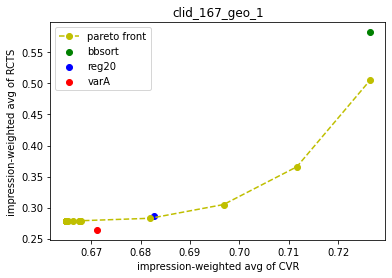

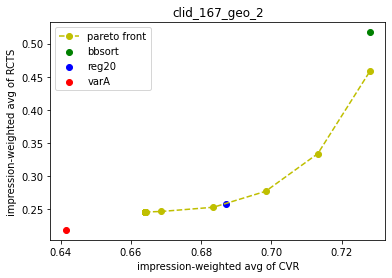

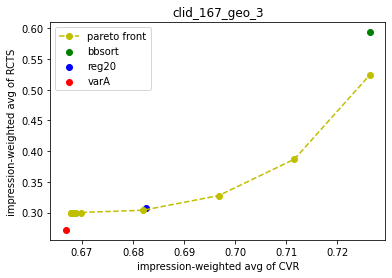

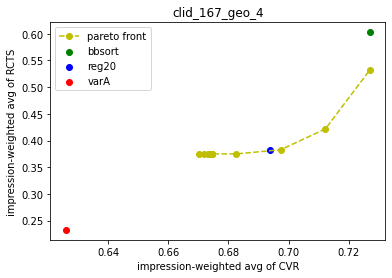

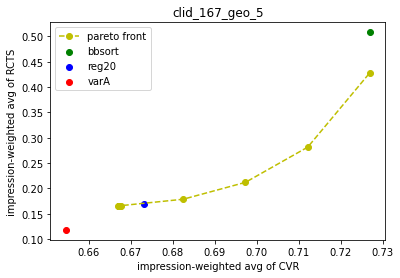

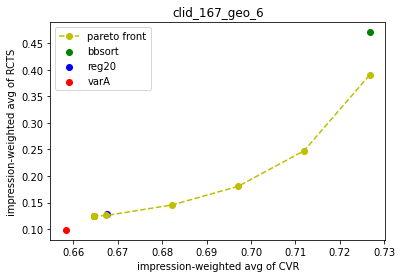

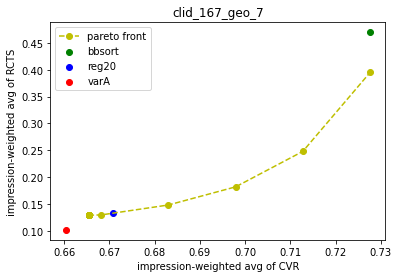

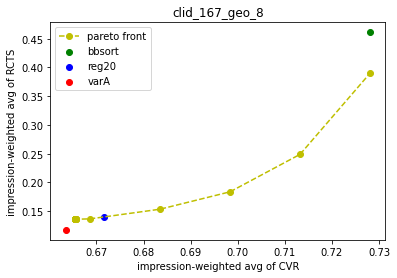

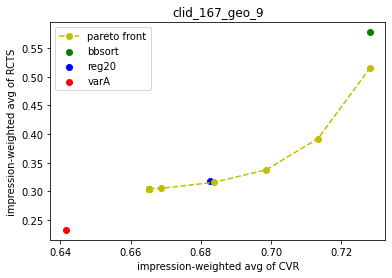

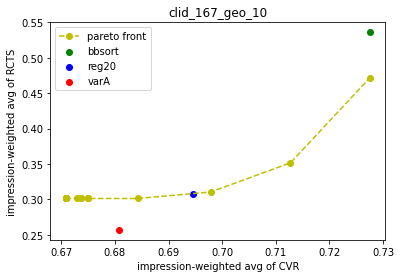

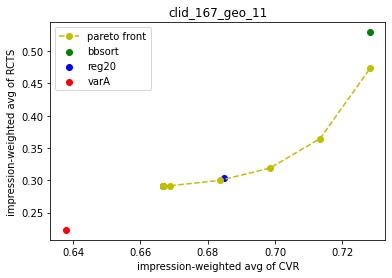

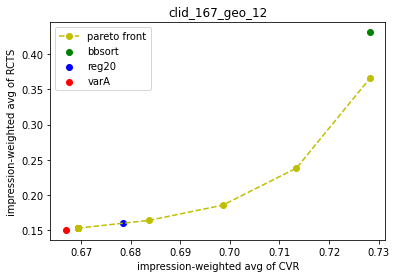

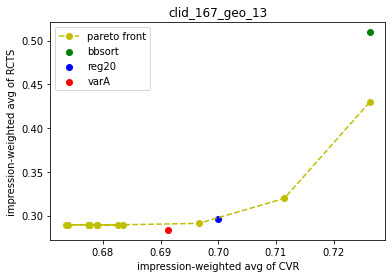

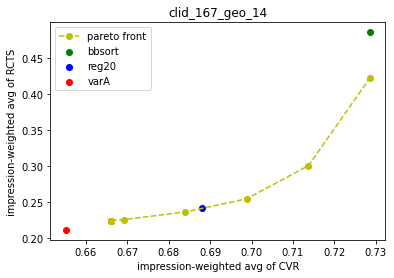

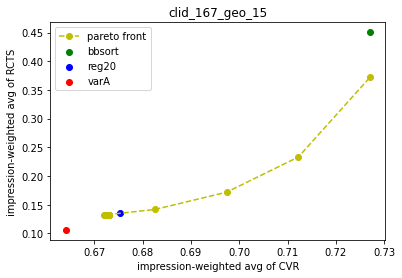

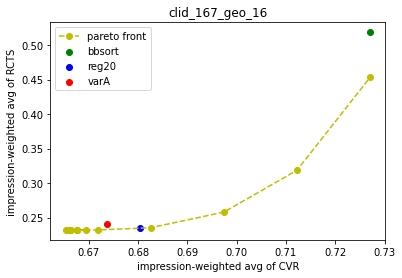

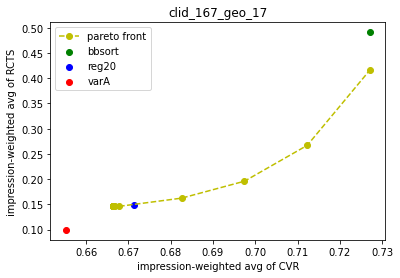

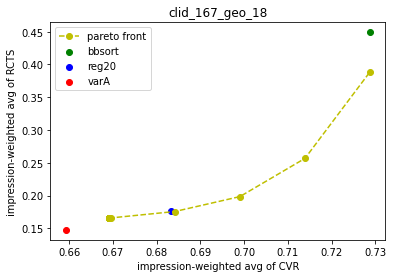

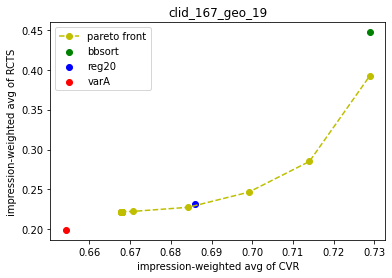

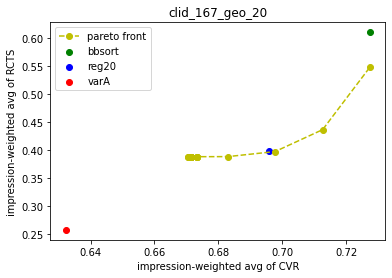

In [5]:
df.to_pickle("df_full_geo_clid_"+str(cid)+"_.pkl")
for cid in set(df['clid']):
    for geoid in set(df['geo']):
        _,_,max_cvr,reg20,varA,pareto = df.loc[(df['clid'] == cid) & (df['geo'] ==geoid)].iloc[0]
        imp_weighted_cvr_by_bbsort,imp_weighted_rcts_by_bbsort = max_cvr[0],max_cvr[1]
        imp_weighted_cvr_by_reg20,imp_weighted_rcts_by_reg20 = reg20[0],reg20[1]
        imp_weighted_cvr_by_varA,imp_weighted_rcts_by_varA = varA[0],varA[1]
        x_val = [x[0] for x in pareto]
        y_val = [x[1] for x in pareto]
        plt.figure()
        plt.plot(x_val,y_val,'--bo',c="y")
        plt.xlabel("impression-weighted avg of CVR")
        plt.ylabel("impression-weighted avg of RCTS")
        plt.scatter(imp_weighted_cvr_by_bbsort,imp_weighted_rcts_by_bbsort,c= "g")
        plt.scatter(imp_weighted_cvr_by_reg20,imp_weighted_rcts_by_reg20,c= "b")
        plt.scatter(imp_weighted_cvr_by_varA,imp_weighted_rcts_by_varA,c= "r")
        location = 0 # For the best location
        legend_drawn_flag = True
        plt.legend(["pareto front","bbsort","reg20", "varA"], loc=0, frameon=legend_drawn_flag)
        plt.title("clid_"+str(cid)+"_geo_"+str(geoid))
        plt.savefig("clid_"+str(cid)+"_geo_"+str(geoid)+".png")
        plt.show()